# External AC Sensor Calibration

## Load data

In [4]:
from oct2py import octave as oc
import logging
oc.addpath('m-files')
oc.logger.setLevel(logging.WARN)

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

pylab.rcParams['figure.figsize'] = (14.0, 10.0)

Populating the interactive namespace from numpy and matplotlib


In [6]:
fileNames = os.listdir('data')

# data from text: # v_bits c_bits v_measured c_measured
V_BITS = 0
C_BITS = 1
V_MEAS = 2
C_MEAS = 3
P_MEAS = 4

sensors = {}
for f in fileNames:
    sensors[f] = np.loadtxt('data/{}'.format(f), skiprows=1)
    p = np.multiply(sensors[f][:,V_MEAS], sensors[f][:,C_MEAS])[...,None] # None keeps (n, 1) shape
    sensors[f] = np.append(sensors[f], p, 1)
    
all_sensors = np.concatenate(sensors.values())

## Initial Look

We can get a quick sense of how the measured values compare to the sensor values:

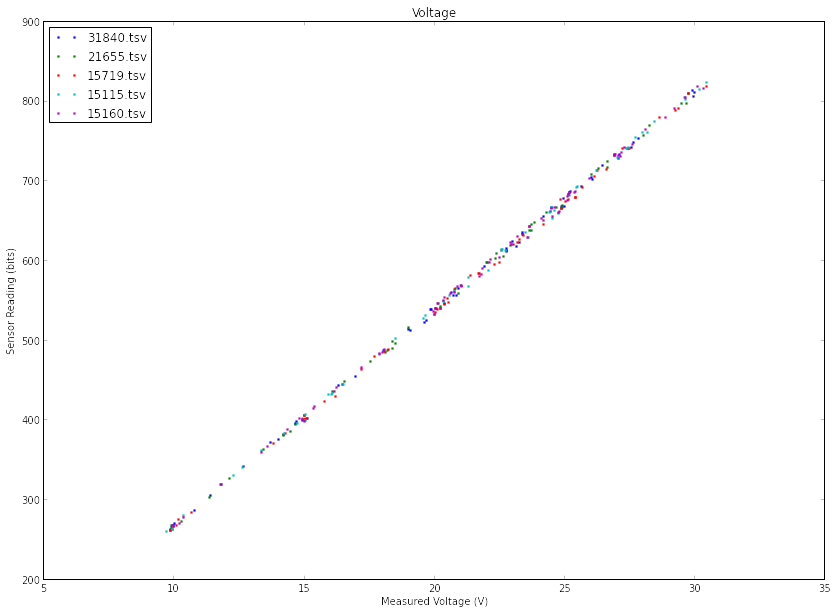

In [7]:
plt.hold(True)
plt.title('Voltage')
plt.xlabel('Measured Voltage (V)')
plt.ylabel('Sensor Reading (bits)')
for s in sensors:
    plt.plot(sensors[s][:,V_MEAS], sensors[s][:,V_BITS], '.', label=s, markersize=5)
plt.legend(loc="upper left")
plt.hold(False)
plt.show()

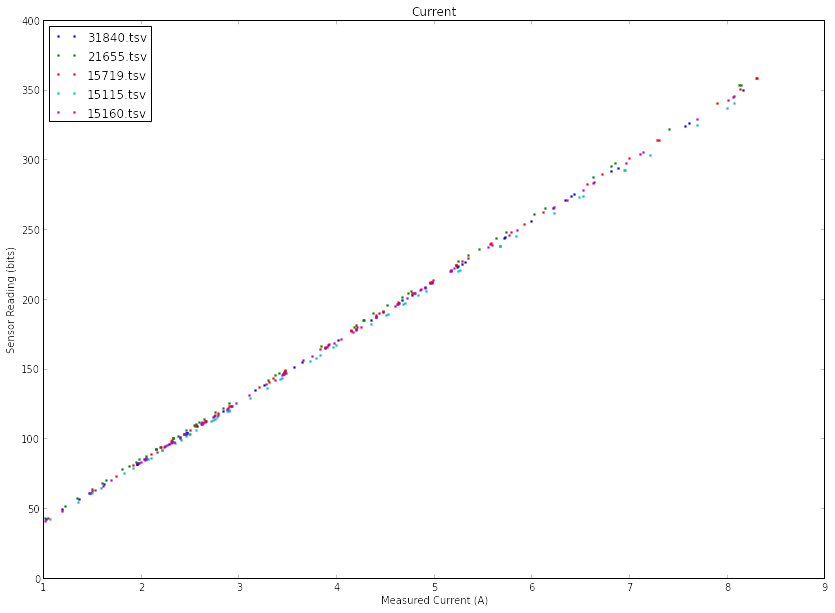

In [8]:
plt.hold(True)
plt.title('Current')
plt.xlabel('Measured Current (A)')
plt.ylabel('Sensor Reading (bits)')
for s in sensors:
    plt.plot(sensors[s][:,C_MEAS], sensors[s][:,C_BITS], '.', label=s, markersize=5)
plt.legend(loc="upper left")
plt.hold(False)
plt.show()

In [43]:
sensorVals = all_sensors[:, V_BITS]
voltageReadings = all_sensors[:, V_MEAS].T
X_v, theta_v, h_v = oc.optimizeVoltageModel(sensorVals, voltageReadings)
print("theta_1: {}\ntheta_2: {}".format(float(theta_v[0]), float(theta_v[1])))

theta_1: 0.218024151388
theta_2: 0.0367219698493


new:
```
theta_1: 0.0862686471809
theta_2: 0.0363799216919
```

Given these values, we can compare the predicted voltage values with the measured values:

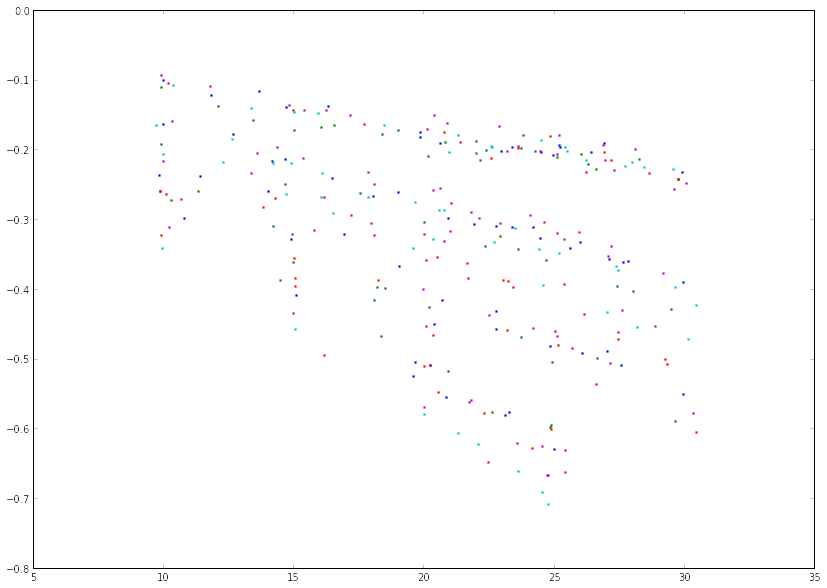

In [45]:
plt.hold(True)

for s in sensors:
    h = oc.predict(sensors[s][:,0], theta_v).T
    err = h-sensors[s][:,2]
    plt.plot(sensors[s][:,2], err.T, '.', markersize=5)
    
plt.hold(False)
plt.show()

## Current Model

In [11]:
X_c, theta_c, h_c = oc.optimizeCurrentModel(all_sensors[:,C_BITS], all_sensors[:, C_MEAS].T)
print("  theta_1: {}".format(float(theta_c[0])))
print("  theta_2: {}".format(float(theta_c[1])))

  theta_1: 0.0647324535112
  theta_2: 0.0231741222528


And looking at the errors:

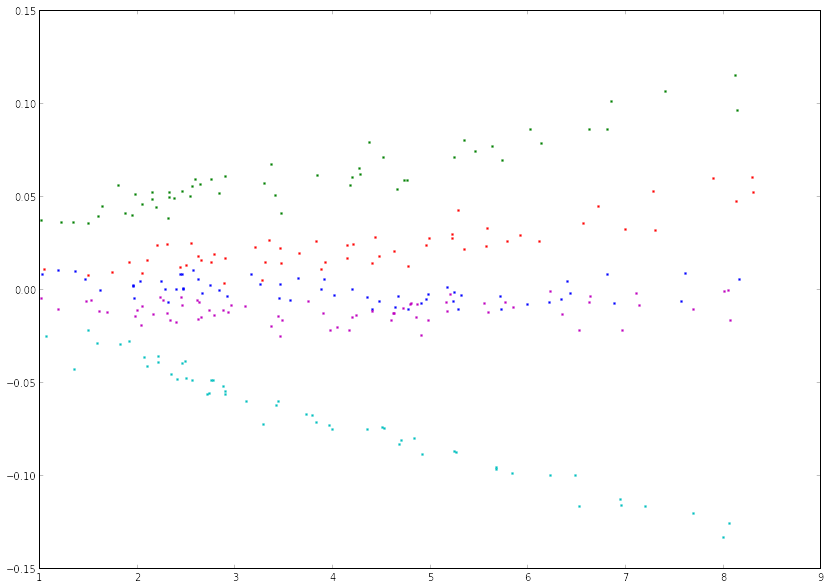

In [12]:
plt.hold(True)

for s in sensors:
    h = oc.predict(sensors[s][:,1], theta_c).T
    err = h-sensors[s][:,3]
    plt.plot(sensors[s][:,3], err.T, '.', markersize=5)
        
plt.hold(False)
plt.show()

# Voltage error vs Current

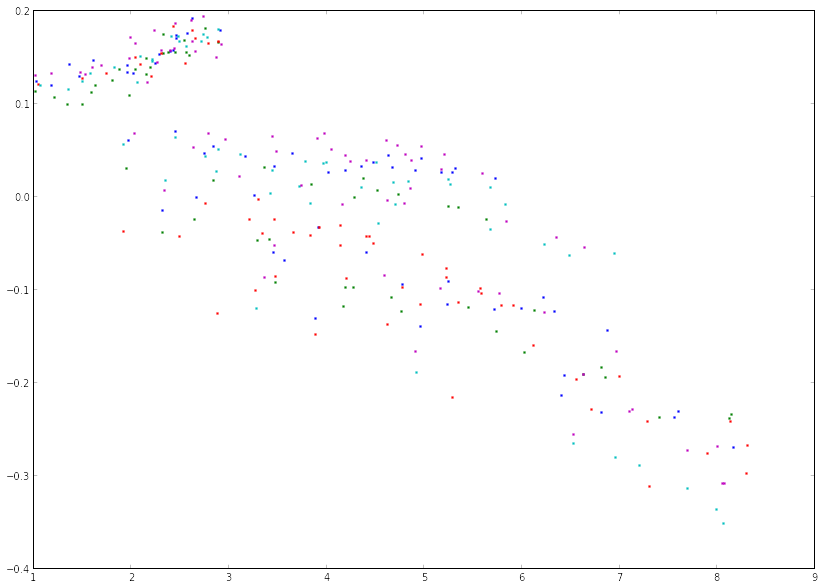

In [13]:
plt.hold(True)

for s in sensors:
    h = oc.predict(sensors[s][:,0], theta_v).T
    err = h-sensors[s][:,2]
    plt.plot(sensors[s][:,3], err.T, '.', markersize=5)
    
plt.hold(False)
plt.show()

new model:

```
power = THETA_0 + THETA_1 * voltage * current + THETA_2 * current
```

In [14]:
X_p1, theta_p1, h_p1 = oc.optimizePowerModel1(all_sensors[:,V_BITS], all_sensors[:,C_BITS], all_sensors[:, P_MEAS].T)
print("  theta_1: {}".format(float(theta_p1[0])))
print("  theta_2: {}".format(float(theta_p1[1])))
print("  theta_3: {}".format(float(theta_p1[2])))
print("  theta_4: {}".format(float(theta_p1[3])))

  theta_1: 0.0645061647257
  theta_2: 0.000856939893588
  theta_3: 0.0101975205892
  theta_4: 6.5967051437e-05


In [15]:
X_p2, theta_p2, h_p2 = oc.optimizePowerModel2(all_sensors[:,V_BITS], all_sensors[:,C_BITS], all_sensors[:, P_MEAS].T)
print("  theta_1: {}".format(float(theta_p2[0])))
print("  theta_2: {}".format(float(theta_p2[1])))

  theta_1: 0.551637533452
  theta_2: 0.000869558375011


In [16]:
rmsErr_p1, errors_p1 = oc.calcError(h_p1.T, all_sensors[:,P_MEAS])
rmsErr_p2, errors_p2 = oc.calcError(h_p2.T, all_sensors[:,P_MEAS])

In [17]:
print rmsErr_p1, rmsErr_p2

0.733136706659 0.75803359036


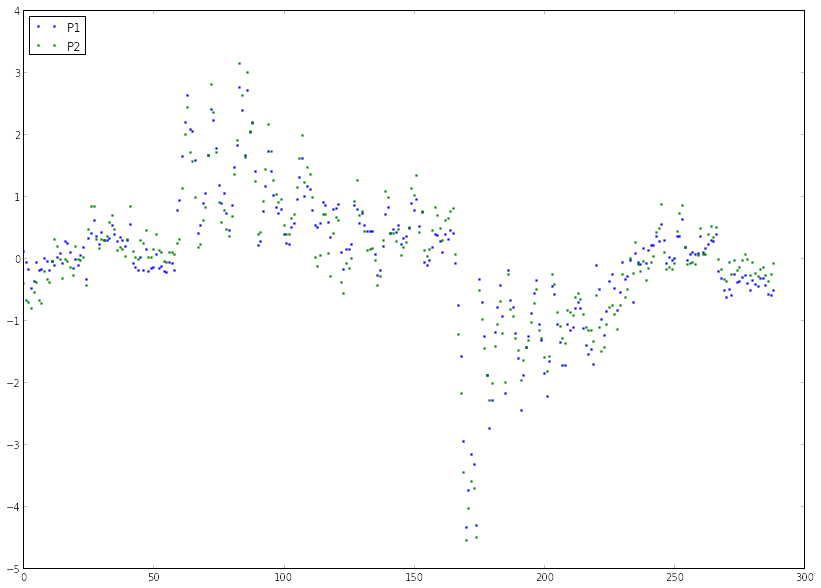

In [18]:
plt.hold(True)
plt.plot(errors_p1, '.', markersize=5, label="P1")
plt.plot(errors_p2, '.', markersize=5, label="P2")
plt.hold(False)
plt.legend(loc="upper left")
plt.show()


# Second data

In [25]:
newdata = np.loadtxt('data2/15855.tsv', skiprows=1)

In [39]:
# v_bits v_measured_supply v_measured_load
newdata

array([[ 288.     ,   10.75   ,   10.55   ],
       [ 345.5215 ,   12.89   ,   12.65   ],
       [ 394.     ,   14.68   ,   14.42   ],
       [ 469.6855 ,   17.48   ,   17.16   ],
       [ 566.03575,   21.05   ,   20.67   ],
       [ 644.     ,   23.93   ,   23.49   ],
       [ 648.0572 ,   24.     ,   23.66   ],
       [ 798.22165,   29.52   ,   29.11   ],
       [ 562.     ,   20.81   ,   20.53   ],
       [ 455.     ,   16.88   ,   16.65   ],
       [ 387.59975,   14.39   ,   14.19   ],
       [ 500.9857 ,   18.56   ,   18.3    ],
       [ 504.     ,   18.623  ,   18.43   ],
       [ 709.5928 ,   26.15   ,   25.89   ],
       [ 813.2001 ,   29.97   ,   29.68   ],
       [ 626.     ,   23.08   ,   22.86   ],
       [ 721.     ,   26.57   ,   26.31   ],
       [ 660.     ,   24.33   ,   24.1    ],
       [ 554.8284 ,   20.47   ,   20.27   ],
       [ 558.05005,   20.53   ,   20.41   ],
       [ 665.     ,   24.42   ,   24.29   ],
       [ 768.     ,   28.19   ,   28.03   ],
       [ 7

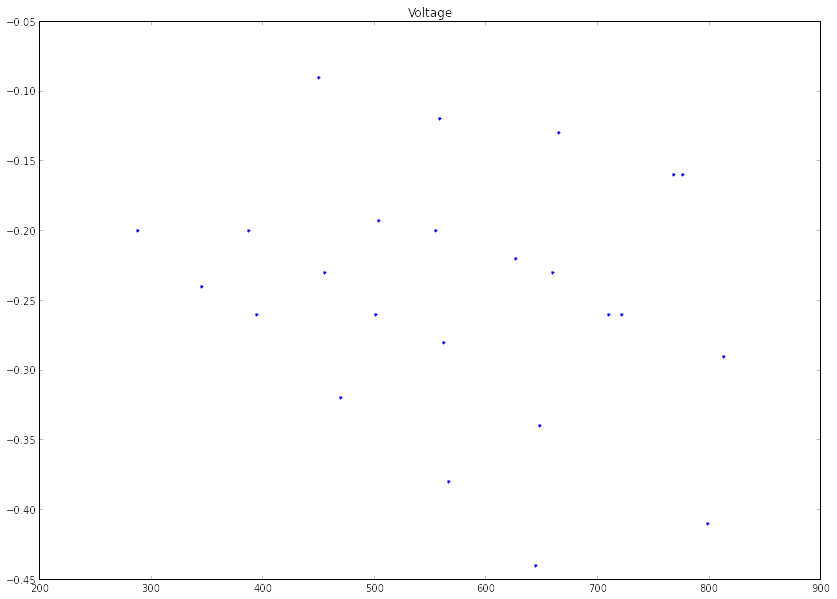

In [47]:
plt.hold(True)
plt.title('Voltage')
plt.plot(newdata[:,0], np.subtract(newdata[:,2], newdata[:,1]), '.')
plt.hold(False)
plt.show()

In [40]:
sensorVals = newdata[:, 0]
voltageReadings = newdata[:, 2].T
X_v, theta_v, h_v = oc.optimizeVoltageModel(sensorVals, voltageReadings)
print("theta_1: {}\ntheta_2: {}".format(float(theta_v[0]), float(theta_v[1])))

theta_1: 0.0862686471809
theta_2: 0.0363799216919
